In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import japanize_matplotlib
from pathlib import Path

# 現在のノートブックからの相対パスを絶対パスに変換
notebook_dir = Path(os.path.abspath('')).parent
data_path = notebook_dir / 'data' / 'processed' / 'wt262avs.adicht_rec2.parquet'

# データの読み込み
df = pd.read_parquet(data_path)

# データの先頭を表示
print("DataFrameの先頭5行:")
display(df.head())

# データの基本情報を表示
print("\nDataFrameの基本情報:")
display(df.info())

DataFrameの先頭5行:


,PFC,PPC,A1,V1,Stimulus,Time_s,Event_ID,Stimulus_Type
0,63.68750,-48.06250,-76.906250,-55.328125,-0.000312,0.000,0,No_Stimulus
1,42.40625,-50.87500,-80.546875,-57.750000,-0.000312,0.001,0,No_Stimulus
2,31.43750,-70.71875,-99.937500,-82.546875,-0.000312,0.002,0,No_Stimulus
3,30.37500,-44.06250,-70.140625,-49.937500,-0.000312,0.003,0,No_Stimulus
4,-4.53125,-58.40625,-88.937500,-58.468750,0.000000,0.004,0,No_Stimulus



DataFrameの基本情報:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240450 entries, 0 to 4240449
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   PFC            float32
 1   PPC            float32
 2   A1             float32
 3   V1             float32
 4   Stimulus       float32
 5   Time_s         float64
 6   Event_ID       int64  
 7   Stimulus_Type  object 
dtypes: float32(5), float64(1), int64(1), object(1)
memory usage: 177.9+ MB


None

In [3]:
from scipy.signal import butter, filtfilt

In [4]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    データにバンドパスフィルタを適用する関数。
    
    Args:
        data (np.array or pd.Series): フィルタをかけるデータ
        lowcut (float): 低域カットオフ周波数 (Hz)
        highcut (float): 高域カットオフ周波数 (Hz)
        fs (int): サンプリング周波数 (Hz)
        order (int): フィルタの次数
        
    Returns:
        np.array: フィルタリングされたデータ
    """
    # 念のため、データの型をfloat64に変換して精度を確保
    data = np.asarray(data, dtype=np.float64)
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def plot_continuous_waveforms(df, channel, fs, start_time_s=10, duration_s=5):
    """
    フィルタリング前後の波形を比較してプロットする関数。
    
    Args:
        df (pd.DataFrame): データフレーム
        channel (str): プロットするチャンネル名
        fs (int): サンプリング周波数 (Hz)
        start_time_s (int): プロット開始時間（秒）
        duration_s (int): プロットする期間（秒）
    """
    # フィルタリング後のカラム名
    filtered_col = f'{channel}_filtered'
    if filtered_col not in df.columns:
        print(f"エラー: {filtered_col} がデータフレームに存在しません。")
        return

    # 時間からインデックスを計算
    start_idx = int(start_time_s * fs)
    end_idx = int((start_time_s + duration_s) * fs)
    
    # プロット対象のデータをスライス
    plot_df = df.iloc[start_idx:end_idx]
    time_axis = np.linspace(start_time_s, start_time_s + duration_s, len(plot_df))

    # グラフ描画
    plt.figure(figsize=(18, 6))
    plt.plot(time_axis, plot_df[channel], label='Original Signal', color='gray', alpha=0.7)
    plt.plot(time_axis, plot_df[filtered_col], label='Filtered Signal (1-40Hz)', color='#1f77b4', linewidth=1.5)
    
    plt.title(f'Waveform Comparison for Channel: {channel}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

フィルタリング処理を開始します...
  - チャンネル 'PFC' の処理が完了しました。
  - チャンネル 'PPC' の処理が完了しました。
  - チャンネル 'A1' の処理が完了しました。
  - チャンネル 'V1' の処理が完了しました。
フィルタリング処理が完了しました。

--- フィルタリング結果の診断 ---

▼ フィルタ前後のデータ比較 (PFCチャンネル):


,PFC,PFC_filtered
0,63.687500,-9.687126
1,42.406250,-16.177164
2,31.437500,-22.393838
3,30.375000,-28.047092
4,-4.531250,-32.896286
5,4.421875,-36.768471
6,-22.343750,-39.570777
7,-37.593750,-41.295758
8,-34.343750,-42.019048
9,-2.140625,-41.889416



▼ 'PFC_filtered' 列のNaNの数: 0
▼ 元の 'PFC' 列のNaNの数: 0


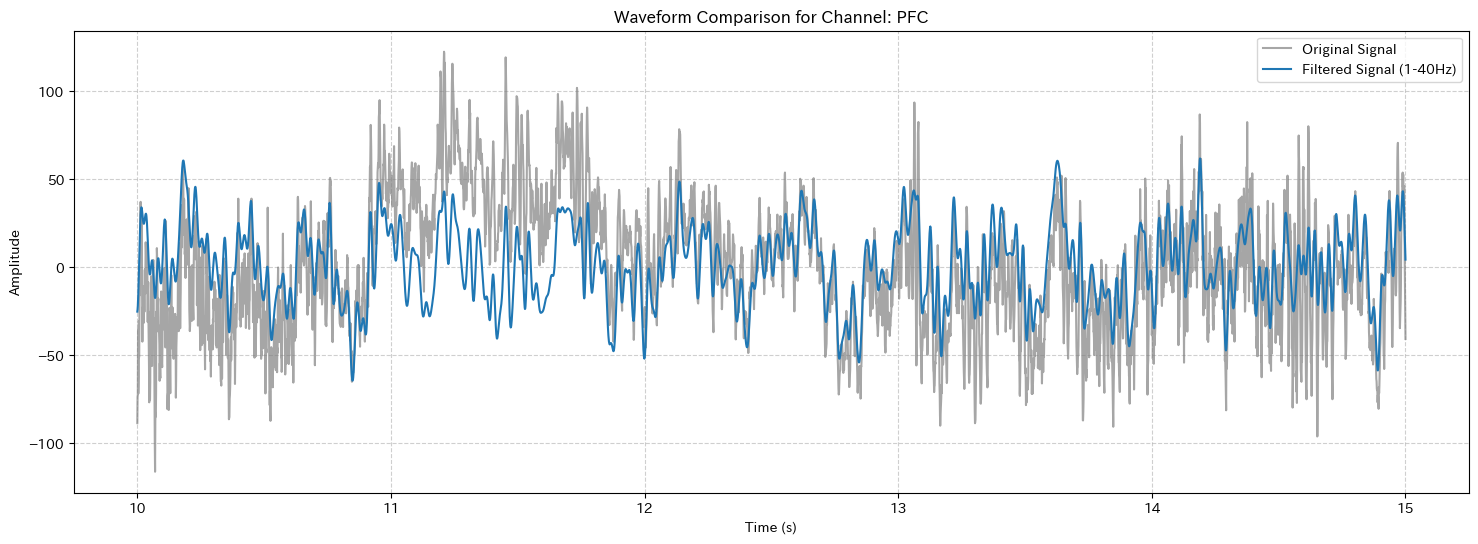

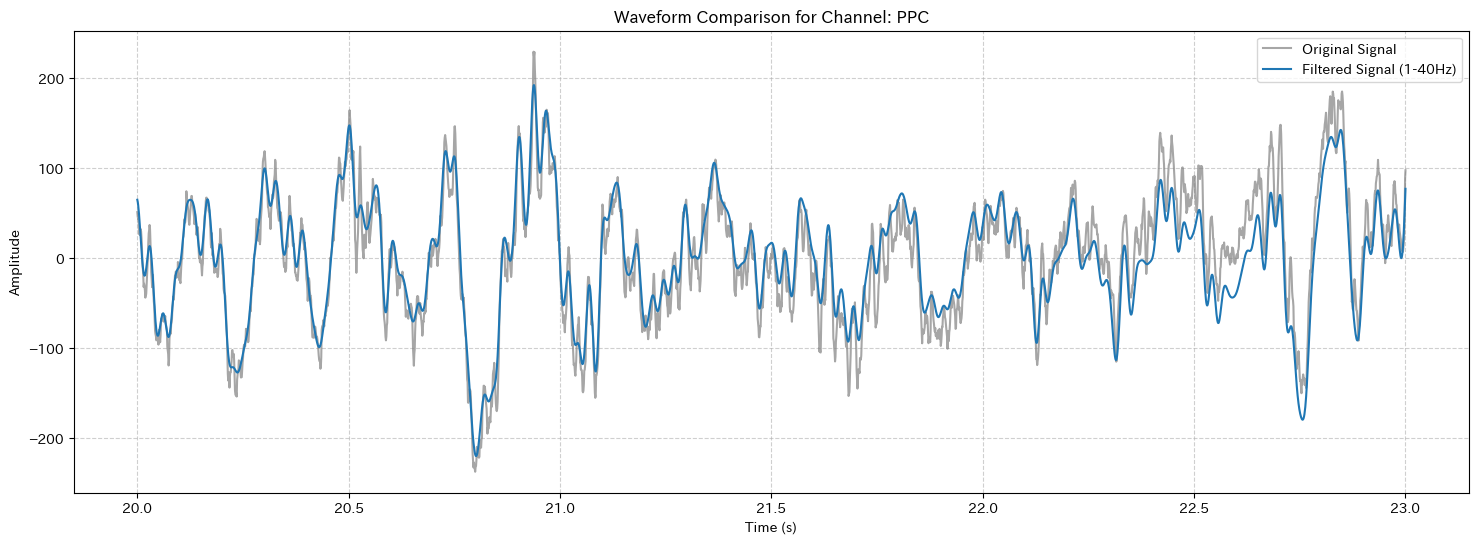

In [5]:
# --- パラメータ設定 ---
SAMPLING_RATE = 1000  # 1000Hz
LOW_CUT = 1.0         # 1Hz
HIGH_CUT = 40.0       # 40Hz
CHANNELS_TO_FILTER = ['PFC', 'PPC', 'A1', 'V1']

# --- フィルタの適用 ---
print("フィルタリング処理を開始します...")
for channel in CHANNELS_TO_FILTER:
    # フィルタリング前の元データ
    original_signal = df[channel].values
    
    # フィルタリング実行
    filtered_signal = bandpass_filter(
        data=original_signal,
        lowcut=LOW_CUT,
        highcut=HIGH_CUT,
        fs=SAMPLING_RATE
    )
    
    # 新しいカラムとしてDataFrameに追加
    df[f'{channel}_filtered'] = filtered_signal
    print(f"  - チャンネル '{channel}' の処理が完了しました。")

print("フィルタリング処理が完了しました。\n")

# ==========================================================
# == ここから診断コードを追加 ==
# ==========================================================
print("--- フィルタリング結果の診断 ---")

# フィルタ前後のデータを10行表示して比較
print("\n▼ フィルタ前後のデータ比較 (PFCチャンネル):")
display(df[['PFC', 'PFC_filtered']].head(10))

# フィルタ後のデータにNaNがいくつあるか確認
nan_count = df['PFC_filtered'].isnull().sum()
print(f"\n▼ 'PFC_filtered' 列のNaNの数: {nan_count}")

# もしNaNが多ければ、元のデータにNaNがないか確認
original_nan_count = df['PFC'].isnull().sum()
print(f"▼ 元の 'PFC' 列のNaNの数: {original_nan_count}")
# ==========================================================
# == 診断コードはここまで ==
# ==========================================================

# --- 結果の可視化 ---
# PFCチャンネルの10秒目から5秒間をプロットして比較
plot_continuous_waveforms(
    df=df,
    channel='PFC',
    fs=SAMPLING_RATE,
    start_time_s=10,
    duration_s=5
)

# PPCチャンネルも確認
plot_continuous_waveforms(
    df=df,
    channel='PPC',
    fs=SAMPLING_RATE,
    start_time_s=20,
    duration_s=3
)

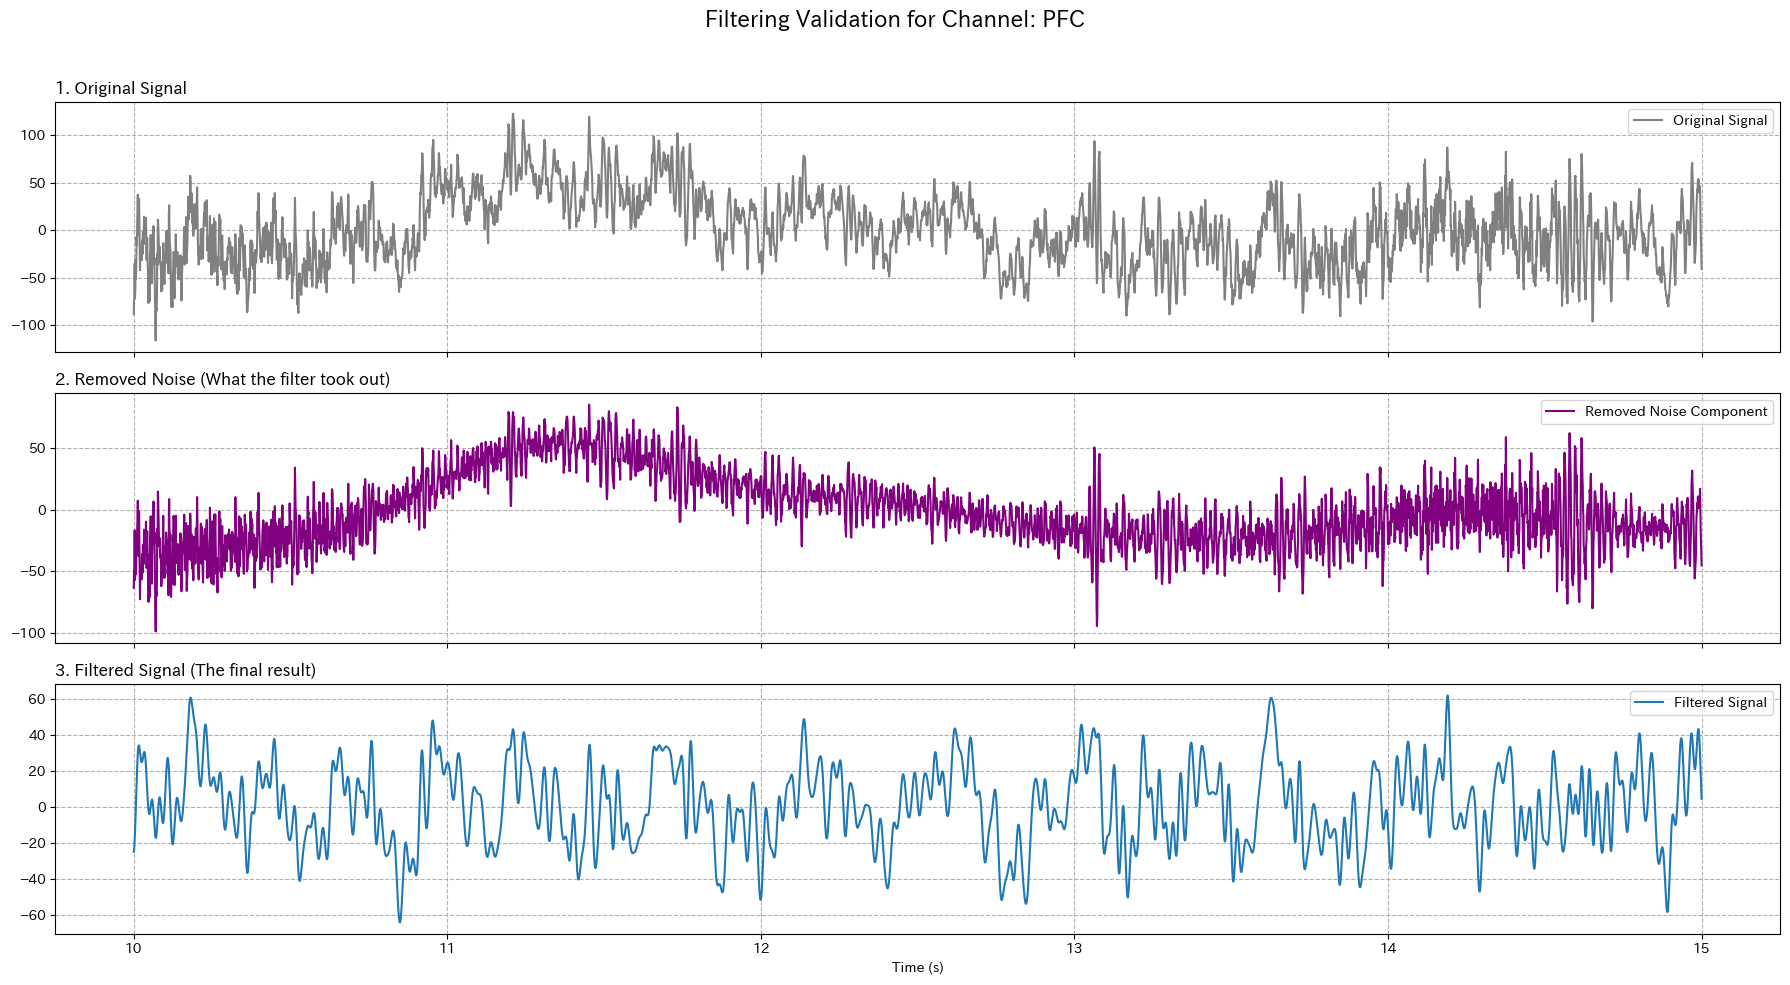

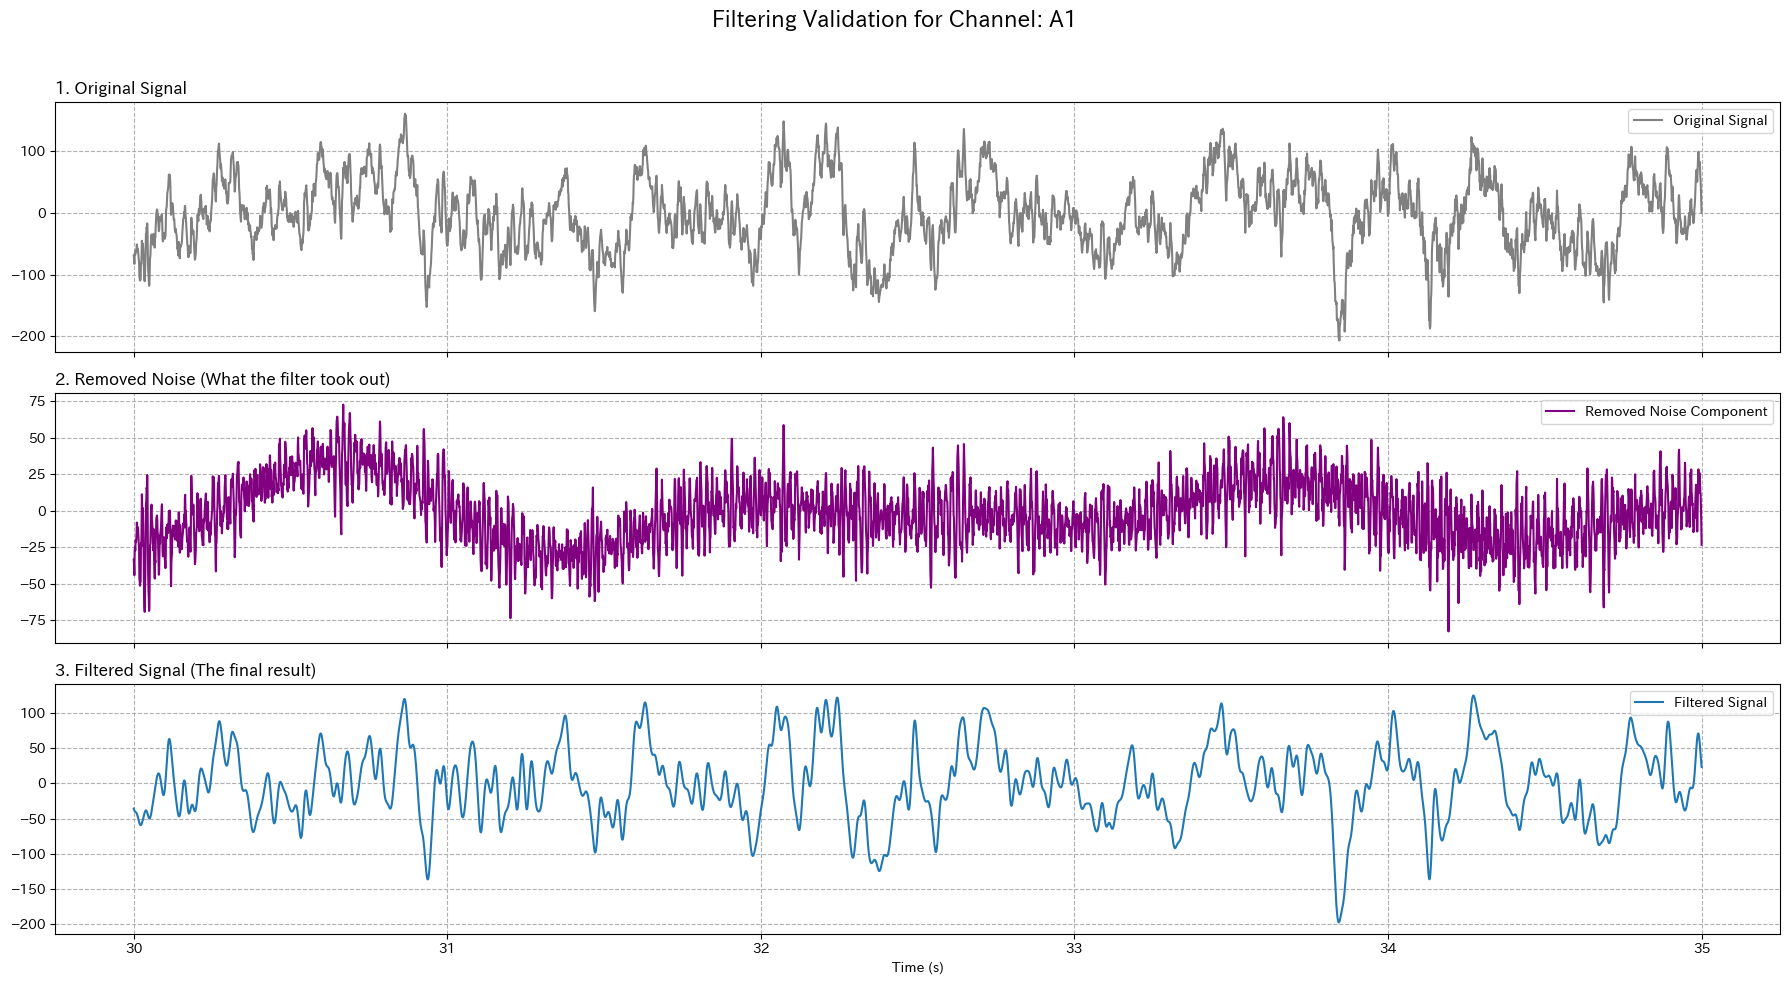

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_validation_signals(df, channel, fs, start_time_s=10, duration_s=5):
    """
    フィルタの妥当性を検証するために3つの信号をプロットする。
    1. 元の信号
    2. 除去されたノイズ成分
    3. フィルタ後の信号
    """
    # 差分から「除去されたノイズ」カラムを作成
    noise_col = f'{channel}_noise'
    filtered_col = f'{channel}_filtered'
    df[noise_col] = df[channel] - df[filtered_col]

    # 時間からインデックスを計算
    start_idx = int(start_time_s * fs)
    end_idx = int((start_time_s + duration_s) * fs)
    
    plot_df = df.iloc[start_idx:end_idx].copy()
    time_axis = np.linspace(start_time_s, start_time_s + duration_s, len(plot_df))

    # 3つのグラフを縦に並べて描画
    fig, axes = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
    
    # 1. 元の信号
    axes[0].plot(time_axis, plot_df[channel], color='gray', label='Original Signal')
    axes[0].set_title('1. Original Signal', loc='left')
    axes[0].legend()
    axes[0].grid(True, linestyle='--')

    # 2. 除去されたノイズ
    axes[1].plot(time_axis, plot_df[noise_col], color='purple', label='Removed Noise Component')
    axes[1].set_title('2. Removed Noise (What the filter took out)', loc='left')
    axes[1].legend()
    axes[1].grid(True, linestyle='--')

    # 3. フィルタ後の信号
    axes[2].plot(time_axis, plot_df[filtered_col], color='#1f77b4', label='Filtered Signal')
    axes[2].set_title('3. Filtered Signal (The final result)', loc='left')
    axes[2].legend()
    axes[2].grid(True, linestyle='--')

    axes[2].set_xlabel('Time (s)')
    fig.suptitle(f'Filtering Validation for Channel: {channel}', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- 実行 ---
# PFCチャンネルで検証
plot_validation_signals(df, 'PFC', fs=1000, start_time_s=10, duration_s=5)

# A1チャンネルでも確認
plot_validation_signals(df, 'A1', fs=1000, start_time_s=30, duration_s=5)

In [25]:
# PFCチャンネルの分散を計算
var_original = df['PFC'].var()
var_filtered = df['PFC_filtered'].var()
var_noise = df['PFC_noise'].var()

print(f"--- PFC Channel Variance Check ---")
print(f"元の信号の分散        : {var_original:.2f}")
print(f"フィルタ後の分散      : {var_filtered:.2f}")
print(f"除去されたノイズの分散: {var_noise:.2f}")
print("-" * 30)
print(f"検証 (フィルタ後 + ノイズ): {var_filtered + var_noise:.2f}")

--- PFC Channel Variance Check ---
元の信号の分散        : 1083.95
フィルタ後の分散      : 662.41
除去されたノイズの分散: 344.11
------------------------------
検証 (フィルタ後 + ノイズ): 1006.52


In [26]:
df

,PFC,PPC,A1,V1,Stimulus,Time_s,Event_ID,Stimulus_Type,PFC_filtered,PPC_filtered,A1_filtered,V1_filtered,PFC_noise,A1_noise
0,63.687500,-48.062500,-76.906250,-55.328125,-0.000312,0.000,0,No_Stimulus,-9.687126,-29.744644,-29.668319,-31.102712,73.374626,-47.237931
1,42.406250,-50.875000,-80.546875,-57.750000,-0.000312,0.001,0,No_Stimulus,-16.177164,-31.208505,-31.960842,-31.552850,58.583414,-48.586033
2,31.437500,-70.718750,-99.937500,-82.546875,-0.000312,0.002,0,No_Stimulus,-22.393838,-32.559073,-34.101970,-31.901094,53.831338,-65.835530
3,30.375000,-44.062500,-70.140625,-49.937500,-0.000312,0.003,0,No_Stimulus,-28.047092,-33.677845,-35.946312,-32.045870,58.422092,-34.194313
4,-4.531250,-58.406250,-88.937500,-58.468750,0.000000,0.004,0,No_Stimulus,-32.896286,-34.466580,-37.366260,-31.903339,28.365036,-51.571240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240445,-62.984375,-158.718750,-168.593750,-116.421875,0.000312,4240.445,0,No_Stimulus,43.648884,60.584508,82.600871,66.890962,-106.633259,-251.194621
4240446,-53.312500,-132.968750,-139.640625,-93.671875,0.000312,4240.446,0,No_Stimulus,39.539087,53.558365,73.985147,58.903303,-92.851587,-213.625772
4240447,-61.390625,-168.953125,-202.812500,-144.781250,0.000000,4240.447,0,No_Stimulus,35.199068,46.009693,64.649319,50.237220,-96.589693,-267.461819
4240448,-48.453125,-159.515625,-190.187500,-142.171875,-0.000312,4240.448,0,No_Stimulus,30.722133,38.159622,54.849376,41.154337,-79.175258,-245.036876
